# 🧠 Análisis de la Readmisión a la UCI en Pacientes con Hemorragia Intracerebral (MIMIC-IV)

## 1. 🔧 Configuración Inicial

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account key file
SERVICE_ACCOUNT_FILE = "mimic-sergi.json"
PROJECT_ID = "ogi-uci-i61"

# Create credentials and client
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE)

client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

# Example query
query = "SELECT 'Hello, World!' AS greeting"
query_job = client.query(query)

# Fetch results
results = query_job.result()

for row in results:
    print(row.greeting)

Hello, World!


## 2. 📦 Extracción de Datos

In [24]:
# SQL query para extraer datos de pacientes con HIC (Hemorragia Intracerebral) en la UCI
query = """
-- Updated SQL query for ICH patients in ICU with corrected joins to derived lab tables
WITH ich_admissions AS (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i
  JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d
    ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version
  WHERE LOWER(d.long_title) LIKE '%intracerebral hemorrhage%'
),

chartevents_avg AS (
  SELECT
    c.stay_id,
    AVG(CASE WHEN itemid = 220045 AND valuenum > 0 THEN valuenum END) AS heart_rate_avg,
    AVG(CASE WHEN itemid = 220052 AND valuenum BETWEEN 30 AND 200 THEN valuenum END) AS mbp_avg,
    AVG(CASE WHEN itemid = 220210 AND valuenum BETWEEN 5 AND 60 THEN valuenum END) AS resp_rate_avg,
    AVG(CASE WHEN itemid = 220277 AND valuenum BETWEEN 70 AND 100 THEN valuenum END) AS spo2_avg,
    AVG(CASE WHEN itemid = 223762 AND valuenum BETWEEN 33 AND 43 THEN valuenum END) AS temperature_avg
  FROM `ogi-uci-i61.mimiciv_icu.chartevents` c
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` i ON c.stay_id = i.stay_id
  WHERE
    c.itemid IN (220045, 220052, 220210, 220277, 223762)
    AND c.valuenum IS NOT NULL
    AND c.charttime BETWEEN i.intime AND i.outtime
  GROUP BY c.stay_id
),

cbc_labs AS (
  SELECT subject_id, hadm_id,
    MIN(wbc) AS wbc_min,
    MIN(hemoglobin) AS hgb_min,
    MIN(hematocrit) AS hct_min
  FROM `ogi-uci-i61.mimiciv_derived.complete_blood_count`
  GROUP BY subject_id, hadm_id
),

chem_labs AS (
  SELECT subject_id, hadm_id,
    MIN(sodium) AS sodium_min,
    MIN(creatinine) AS creatinine_min,
    MIN(glucose) AS glucose_min
  FROM `ogi-uci-i61.mimiciv_derived.chemistry`
  GROUP BY subject_id, hadm_id
),

coag_labs AS (
  SELECT subject_id, hadm_id,
    MIN(inr) AS inr_min,
    MIN(pt) AS pt_min
  FROM `ogi-uci-i61.mimiciv_derived.coagulation`
  GROUP BY subject_id, hadm_id
),

readmission_within_30_days AS (
  SELECT
    a1.subject_id,
    a1.stay_id,
    MIN(a2.stay_id) AS readmitted_stay
  FROM `ogi-uci-i61.mimiciv_icu.icustays` a1
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` a2
    ON a1.subject_id = a2.subject_id
    AND a2.intime > a1.outtime
    AND DATETIME_DIFF(a2.intime, a1.outtime, DAY) <= 30
  GROUP BY a1.subject_id, a1.stay_id
)

SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  p.anchor_age AS age,
  a.intime,
  a.outtime,
  a.first_careunit,
  TIMESTAMP_DIFF(a.outtime, a.intime, HOUR) AS icu_los_hours,
  TIMESTAMP_DIFF(adm.dischtime, adm.admittime, HOUR) AS hosp_los_hours,
  adm.discharge_location,
  adm.hospital_expire_flag,

  STRING_AGG(CASE WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN i.icd_code END, '; ') AS ich_icd_codes,
  STRING_AGG(CASE WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN CONCAT(i.icd_code, ': ', d.long_title) ELSE i.icd_code END, '; ') AS all_diagnoses,

  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,

  vitals.heart_rate,
  vitals.mbp,
  vitals.resp_rate,
  vitals.temperature,
  vitals.spo2,
  ce.heart_rate_avg,
  ce.mbp_avg,
  ce.resp_rate_avg,
  ce.spo2_avg,
  ce.temperature_avg,

  -- Derived Scores and Labs
  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  code_status.dnr,
  code_status.dni,
  code_status.fullcode,
  code_status.cmo,
  cbc.wbc_min, cbc.hgb_min, cbc.hct_min,
  chem.sodium_min, chem.creatinine_min, chem.glucose_min,
  coag.inr_min, coag.pt_min,

  CASE WHEN hyper.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hypertension,
  CASE WHEN hydro.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hydrocephalus,
  CASE WHEN cad.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_cad,
  CASE WHEN anticoag.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_anticoagulation,
  CASE WHEN neuroproc.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS had_neurosurgery,
  CASE WHEN addmeds.subject_id IS NOT NULL THEN 1 ELSE 0 END AS on_statins_or_antiplatelets,

  readmit.readmitted_stay

FROM `ogi-uci-i61.mimiciv_icu.icustays` a
JOIN `ogi-uci-i61.mimiciv_hosp.patients` p ON a.subject_id = p.subject_id
JOIN `ogi-uci-i61.mimiciv_hosp.admissions` adm ON a.hadm_id = adm.hadm_id
JOIN ich_admissions ich ON a.hadm_id = ich.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i ON a.hadm_id = i.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version

LEFT JOIN (
  SELECT stay_id, gcs_verbal, gcs_motor, gcs_eyes,
         ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.gcs`
) s ON a.stay_id = s.stay_id AND s.rn = 1

LEFT JOIN (
  SELECT stay_id, heart_rate, mbp, resp_rate, temperature, spo2,
         ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.vitalsign`
) vitals ON a.stay_id = vitals.stay_id AND vitals.rn = 1

LEFT JOIN chartevents_avg ce ON a.stay_id = ce.stay_id
LEFT JOIN readmission_within_30_days readmit ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id

-- Derived Scores and Corrected Lab Joins
LEFT JOIN `ogi-uci-i61.mimiciv_derived.charlson` charlson ON a.hadm_id = charlson.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_derived.apsiii` apsi ON a.stay_id = apsi.stay_id
LEFT JOIN `ogi-uci-i61.mimiciv_derived.code_status` code_status ON a.stay_id = code_status.stay_id
LEFT JOIN cbc_labs cbc ON a.subject_id = cbc.subject_id AND a.hadm_id = cbc.hadm_id
LEFT JOIN chem_labs chem ON a.subject_id = chem.subject_id AND a.hadm_id = chem.hadm_id
LEFT JOIN coag_labs coag ON a.subject_id = coag.subject_id AND a.hadm_id = coag.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '401%' OR icd_code LIKE 'I10%'
) hyper ON a.hadm_id = hyper.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '331.3' OR icd_code LIKE 'G91%'
) hydro ON a.hadm_id = hydro.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '414%' OR icd_code LIKE 'I25%'
) cad ON a.hadm_id = cad.hadm_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(warfarin|heparin|apixaban|rivaroxaban|dabigatran)')
    AND drug_type = 'MAIN'
) anticoag ON a.subject_id = anticoag.subject_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(aspirin|clopidogrel|atorvastatin|rosuvastatin)')
    AND drug_type = 'MAIN'
) addmeds ON a.subject_id = addmeds.subject_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.procedures_icd`
  WHERE icd_code LIKE '01%' OR icd_code LIKE '02%'
) neuroproc ON a.hadm_id = neuroproc.hadm_id

GROUP BY
  a.subject_id, a.hadm_id, a.stay_id, a.intime, a.outtime, a.first_careunit,
  p.gender, p.anchor_age, adm.admittime, adm.dischtime, adm.discharge_location, adm.hospital_expire_flag,
  s.gcs_verbal, s.gcs_motor, s.gcs_eyes,
  vitals.heart_rate, vitals.mbp, vitals.resp_rate, vitals.temperature, vitals.spo2,
  ce.heart_rate_avg, ce.mbp_avg, ce.resp_rate_avg, ce.spo2_avg, ce.temperature_avg,
  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  code_status.dnr, code_status.dni, code_status.fullcode, code_status.cmo,
  cbc.wbc_min, cbc.hgb_min, cbc.hct_min,
  chem.sodium_min, chem.creatinine_min, chem.glucose_min,
  coag.inr_min, coag.pt_min,
  hyper.hadm_id, hydro.hadm_id, cad.hadm_id,
  anticoag.subject_id, addmeds.subject_id, neuroproc.hadm_id,
  readmit.readmitted_stay

"""

# Ejecutar la consulta
df = client.query(query).to_dataframe()

df

,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,glucose_min,inr_min,pt_min,has_hypertension,has_hydrocephalus,has_cad,has_anticoagulation,had_neurosurgery,on_statins_or_antiplatelets,readmitted_stay
0,15206760,22941019,34608437,F,65,2133-09-06 02:49:00,2133-09-09 19:17:58,Neuro Surgical Intensive Care Unit (Neuro SICU),89,87,...,98.0,1.1,11.5,1,0,0,1,0,0,<NA>
1,18217587,27289484,32792832,M,79,2125-04-30 03:39:00,2125-05-01 22:14:57,Neuro Intermediate,43,207,...,93.0,1.2,13.4,0,0,1,1,0,1,<NA>
2,17689755,21438160,38033217,M,71,2182-05-18 12:52:31,2182-06-12 18:24:26,Neuro Intermediate,606,747,...,76.0,1.1,11.5,0,0,1,1,1,1,36220822
3,12026790,23977148,31641088,M,81,2154-12-14 05:58:00,2154-12-15 14:05:39,Neuro Intermediate,33,157,...,89.0,1.2,12.8,1,0,0,1,0,0,<NA>
4,14415980,20050520,34506093,F,78,2122-06-14 21:56:00,2122-06-17 14:15:40,Neuro Surgical Intensive Care Unit (Neuro SICU),65,169,...,95.0,1.1,11.4,1,0,0,1,1,0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,13671002,24843042,38940361,M,42,2122-03-21 18:50:00,2122-03-24 14:24:22,Trauma SICU (TSICU),68,66,...,158.0,1.1,12.7,0,0,0,0,1,0,<NA>
4248,18225366,23045632,38301754,M,59,2156-12-16 21:35:00,2156-12-26 15:28:20,Neuro Surgical Intensive Care Unit (Neuro SICU),234,233,...,105.0,1.1,12.1,1,0,0,1,0,0,<NA>
4249,16248948,25054367,37646192,M,54,2184-09-02 04:40:00,2184-09-03 10:39:46,Surgical Intensive Care Unit (SICU),30,18,...,106.0,1.5,17.0,1,0,0,0,0,0,<NA>
4250,19332334,21729847,37357335,F,81,2139-04-15 15:17:00,2139-04-16 17:01:26,Surgical Intensive Care Unit (SICU),26,407,...,77.0,1.1,12.7,1,0,1,1,0,1,<NA>


In [7]:
# SQL query para extraer datos de pacientes con HIC (Hemorragia Intracerebral) en la UCI
query = """
-- SQL query to extract ICU stays for patients with ICH, including raw vitals from chartevents
WITH ich_admissions AS (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.diagnoses_icd i
  JOIN ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses d
    ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version
  WHERE LOWER(d.long_title) LIKE '%intracerebral hemorrhage%'
),

-- Raw vitals and GCS from chartevents
chartevents_avg AS (
  SELECT
    c.stay_id,
    AVG(CASE WHEN itemid = 220045 AND valuenum > 0 THEN valuenum END) AS heart_rate_avg,
    AVG(CASE WHEN itemid = 220052 AND valuenum BETWEEN 30 AND 200 THEN valuenum END) AS mbp_avg,
    AVG(CASE WHEN itemid = 220210 AND valuenum BETWEEN 5 AND 60 THEN valuenum END) AS resp_rate_avg,
    AVG(CASE WHEN itemid = 220277 AND valuenum BETWEEN 70 AND 100 THEN valuenum END) AS spo2_avg,
    AVG(CASE WHEN itemid = 223762 AND valuenum BETWEEN 33 AND 43 THEN valuenum END) AS temperature_avg,
  FROM ogi-uci-i61.mimiciv_icu.chartevents c
  JOIN ogi-uci-i61.mimiciv_icu.icustays i
    ON c.stay_id = i.stay_id
  WHERE
    c.itemid IN (
      220045, 220052, 220210, 220277,
      223762
    )
    AND c.valuenum IS NOT NULL
    AND c.charttime BETWEEN i.intime AND i.outtime
  GROUP BY c.stay_id
)

SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  p.anchor_age AS age,
  a.intime,
  a.outtime,
  TIMESTAMP_DIFF(a.outtime, a.intime, HOUR) AS icu_los_hours,

  -- Diagnoses aggregation
  STRING_AGG(
    CASE 
      WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' 
      THEN i.icd_code 
    END, 
    '; '
  ) AS ich_icd_codes,
  STRING_AGG(
    CASE 
      WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' 
      THEN CONCAT(i.icd_code, ': ', d.long_title) 
      ELSE i.icd_code 
    END, 
    '; '
  ) AS all_diagnoses,

  -- From mimiciv_derived.gcs
  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,

  -- From mimiciv_derived.vitalsign
  vitals.heart_rate,
  vitals.mbp,
  vitals.resp_rate,
  vitals.temperature,
  vitals.spo2,

  -- From chartevents
  ce.heart_rate_avg,
  ce.mbp_avg,
  ce.resp_rate_avg,
  ce.spo2_avg,
  ce.temperature_avg,

  -- Comorbidities and interventions
  CASE WHEN hyper.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hypertension,
  CASE WHEN hydro.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hydrocephalus,
  CASE WHEN cad.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_cad,
  CASE WHEN anticoag.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_anticoagulation,
  CASE WHEN neuroproc.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS had_neurosurgery,

  -- Readmission outcome
  readmit.readmitted_stay

FROM
  ogi-uci-i61.mimiciv_icu.icustays a
JOIN
  ogi-uci-i61.mimiciv_hosp.patients p ON a.subject_id = p.subject_id
JOIN
  ich_admissions ich ON a.hadm_id = ich.hadm_id
LEFT JOIN
  ogi-uci-i61.mimiciv_hosp.diagnoses_icd i ON a.hadm_id = i.hadm_id
LEFT JOIN
  ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses d ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version

-- Derived GCS and vitals
LEFT JOIN (
  SELECT
    stay_id,
    gcs_verbal,
    gcs_motor,
    gcs_eyes,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM ogi-uci-i61.mimiciv_derived.gcs
) s ON a.stay_id = s.stay_id AND s.rn = 1

LEFT JOIN (
  SELECT
    stay_id,
    heart_rate,
    mbp,
    resp_rate,
    temperature,
    spo2,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM ogi-uci-i61.mimiciv_derived.vitalsign
) vitals ON a.stay_id = vitals.stay_id AND vitals.rn = 1

-- Join to chartevents subquery
LEFT JOIN chartevents_avg ce ON a.stay_id = ce.stay_id

-- Readmission detection
LEFT JOIN (
  SELECT
    a1.subject_id,
    a1.stay_id,
    MIN(a2.stay_id) AS readmitted_stay
  FROM ogi-uci-i61.mimiciv_icu.icustays a1
  JOIN ogi-uci-i61.mimiciv_icu.icustays a2
    ON a1.subject_id = a2.subject_id AND a2.intime > a1.outtime
  GROUP BY a1.subject_id, a1.stay_id
) readmit ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id

-- Comorbidities and treatments
LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.diagnoses_icd
  WHERE icd_code LIKE '401%' OR icd_code LIKE 'I10%'
) hyper ON a.hadm_id = hyper.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.diagnoses_icd
  WHERE icd_code LIKE '331.3' OR icd_code LIKE 'G91%'
) hydro ON a.hadm_id = hydro.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.diagnoses_icd
  WHERE icd_code LIKE '414%' OR icd_code LIKE 'I25%'
) cad ON a.hadm_id = cad.hadm_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM ogi-uci-i61.mimiciv_hosp.prescriptions
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(warfarin|heparin|apixaban|rivaroxaban|dabigatran)')
    AND drug_type = 'MAIN'
) anticoag ON a.subject_id = anticoag.subject_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.procedures_icd
  WHERE icd_code LIKE '01%' OR icd_code LIKE '02%'
) neuroproc ON a.hadm_id = neuroproc.hadm_id

GROUP BY
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  p.anchor_age,
  a.intime,
  a.outtime,
  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,
  vitals.heart_rate,
  vitals.mbp,
  vitals.resp_rate,
  vitals.temperature,
  vitals.spo2,
  ce.heart_rate_avg,
  ce.mbp_avg,
  ce.resp_rate_avg,
  ce.spo2_avg,
  ce.temperature_avg,
  hyper.hadm_id,
  hydro.hadm_id,
  cad.hadm_id,
  anticoag.subject_id,
  neuroproc.hadm_id,
  readmit.readmitted_stay

"""

# Ejecutar la consulta
df = client.query(query).to_dataframe()

df




/opt/homebrew/Caskroom/miniforge/base/envs/ogi/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,subject_id,hadm_id,stay_id,gender,age,intime,outtime,icu_los_hours,ich_icd_codes,all_diagnoses,...,mbp_avg,resp_rate_avg,spo2_avg,temperature_avg,has_hypertension,has_hydrocephalus,has_cad,has_anticoagulation,had_neurosurgery,readmitted_stay
0,14007703,20762544,39892146,M,73,2113-09-07 17:58:00,2113-09-10 14:13:30,69,I614,C7931; I614: Nontraumatic intracerebral hemorr...,...,NaN,15.015873,97.968254,NaN,1,0,0,1,0,<NA>
1,19620109,27886137,37815357,F,66,2132-10-17 00:54:00,2132-10-19 00:30:53,48,431,431: Intracerebral hemorrhage; 3485; 4373; 277...,...,NaN,17.638298,96.191489,NaN,1,0,1,1,0,<NA>
2,11281396,20676571,38182969,F,32,2170-10-06 08:57:45,2170-10-16 17:35:12,249,431,1916; 3485; 431: Intracerebral hemorrhage; 331...,...,104.500000,16.141129,96.600806,NaN,0,0,0,1,1,<NA>
3,10143468,26786958,36776139,F,50,2197-01-12 05:52:16,2197-02-15 22:33:27,833,I618,I6032; G935; J690; J156; J9601; G936; I67848; ...,...,97.907731,19.677907,99.656214,37.619437,1,1,0,1,0,<NA>
4,18777918,24753501,37270064,F,19,2157-05-17 14:03:35,2157-06-24 14:13:09,912,I615,D761; A419; I615: Nontraumatic intracerebral h...,...,88.988711,28.883978,97.461883,37.536364,0,0,0,1,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,17996251,25985920,32534960,M,59,2170-02-04 10:12:00,2170-02-07 22:26:52,84,431,03842; 486; 431: Intracerebral hemorrhage; 348...,...,NaN,20.235294,96.074074,NaN,1,0,0,1,0,34676848
3714,15995107,28252521,32227870,M,70,2154-01-18 14:07:47,2154-01-24 18:24:46,148,I618,R061; E669; E875; I959; Y92239; I63413; I6012;...,...,NaN,15.048000,95.598425,NaN,0,0,0,1,1,<NA>
3715,12812042,28574278,35336938,F,43,2159-06-28 22:29:43,2159-06-30 18:41:43,44,I615; I611,B377; J9691; D65; I214; J189; I615: Nontraumat...,...,NaN,27.000000,98.000000,NaN,0,0,0,0,1,<NA>
3716,16379037,23430414,39636496,F,84,2177-04-17 00:14:00,2177-04-22 19:47:27,139,431,1983; 3485; 431: Intracerebral hemorrhage; 277...,...,NaN,19.211679,96.637037,NaN,1,0,0,1,0,<NA>


In [6]:
query = """
-- Step 1: Identify hospital admissions with ICH diagnosis
WITH ich_admissions AS (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.diagnoses_icd i
  JOIN ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses d
    ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version
  WHERE LOWER(d.long_title) LIKE '%intracerebral hemorrhage%'
),

-- Step 2: Compute average vitals from chartevents
chartevents_avg AS (
  SELECT
    c.stay_id,
    AVG(CASE WHEN itemid = 220045 AND valuenum > 0 THEN valuenum END) AS heart_rate_avg,
    AVG(CASE WHEN itemid = 220052 AND valuenum BETWEEN 30 AND 200 THEN valuenum END) AS mbp_avg,
    AVG(CASE WHEN itemid = 220210 AND valuenum BETWEEN 5 AND 60 THEN valuenum END) AS resp_rate_avg,
    AVG(CASE WHEN itemid = 220277 AND valuenum BETWEEN 70 AND 100 THEN valuenum END) AS spo2_avg,
    AVG(CASE WHEN itemid = 223762 AND valuenum BETWEEN 33 AND 43 THEN valuenum END) AS temperature_avg
  FROM ogi-uci-i61.mimiciv_icu.chartevents c
  JOIN ogi-uci-i61.mimiciv_icu.icustays i ON c.stay_id = i.stay_id
  WHERE c.itemid IN (220045, 220052, 220210, 220277, 223762)
    AND c.valuenum IS NOT NULL
    AND c.charttime BETWEEN i.intime AND i.outtime
  GROUP BY c.stay_id
)

-- Step 3: Main data extraction query
SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  p.anchor_age AS age,
  adm.admittime,
  adm.dischtime,
  TIMESTAMP_DIFF(adm.dischtime, adm.admittime, HOUR) AS hosp_los_hours,
  a.intime,
  a.outtime,
  TIMESTAMP_DIFF(a.outtime, a.intime, HOUR) AS icu_los_hours,

  -- Diagnosis info
  STRING_AGG(CASE 
               WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN i.icd_code 
             END, '; ') AS ich_icd_codes,

  STRING_AGG(CASE 
               WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' 
               THEN CONCAT(i.icd_code, ': ', d.long_title)
               ELSE i.icd_code 
             END, '; ') AS all_diagnoses,

  -- GCS scores
  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,

  -- Derived vitals
  vitals.heart_rate,
  vitals.mbp,
  vitals.resp_rate,
  vitals.temperature,
  vitals.spo2,

  -- Raw vitals from chartevents
  ce.heart_rate_avg,
  ce.mbp_avg,
  ce.resp_rate_avg,
  ce.spo2_avg,
  ce.temperature_avg,

  -- Comorbidities and interventions
  CASE WHEN hyper.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hypertension,
  CASE WHEN hydro.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hydrocephalus,
  CASE WHEN cad.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_cad,
  CASE WHEN anticoag.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_anticoagulation,
  CASE WHEN neuroproc.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS had_neurosurgery,

  -- Readmission info
  readmit.readmitted_stay

FROM ogi-uci-i61.mimiciv_icu.icustays a

-- Join patient and diagnosis data
JOIN ogi-uci-i61.mimiciv_hosp.patients p ON a.subject_id = p.subject_id
JOIN ich_admissions ich ON a.hadm_id = ich.hadm_id
JOIN ogi-uci-i61.mimiciv_hosp.admissions adm ON a.hadm_id = adm.hadm_id
LEFT JOIN ogi-uci-i61.mimiciv_hosp.diagnoses_icd i ON a.hadm_id = i.hadm_id
LEFT JOIN ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses d ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version

-- First GCS score per stay
LEFT JOIN (
  SELECT stay_id, gcs_verbal, gcs_motor, gcs_eyes,
         ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM ogi-uci-i61.mimiciv_derived.gcs
) s ON a.stay_id = s.stay_id AND s.rn = 1

-- First derived vital sign per stay
LEFT JOIN (
  SELECT stay_id, heart_rate, mbp, resp_rate, temperature, spo2,
         ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM ogi-uci-i61.mimiciv_derived.vitalsign
) vitals ON a.stay_id = vitals.stay_id AND vitals.rn = 1

-- Chartevents vitals
LEFT JOIN chartevents_avg ce ON a.stay_id = ce.stay_id

-- Readmission detection
LEFT JOIN (
  SELECT a1.subject_id, a1.stay_id, MIN(a2.stay_id) AS readmitted_stay
  FROM ogi-uci-i61.mimiciv_icu.icustays a1
  JOIN ogi-uci-i61.mimiciv_icu.icustays a2
    ON a1.subject_id = a2.subject_id AND a2.intime > a1.outtime
  GROUP BY a1.subject_id, a1.stay_id
) readmit ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id

-- Comorbidity flags
LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.diagnoses_icd
  WHERE icd_code LIKE '401%' OR icd_code LIKE 'I10%'
) hyper ON a.hadm_id = hyper.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.diagnoses_icd
  WHERE icd_code LIKE '331.3' OR icd_code LIKE 'G91%'
) hydro ON a.hadm_id = hydro.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.diagnoses_icd
  WHERE icd_code LIKE '414%' OR icd_code LIKE 'I25%'
) cad ON a.hadm_id = cad.hadm_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM ogi-uci-i61.mimiciv_hosp.prescriptions
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(warfarin|heparin|apixaban|rivaroxaban|dabigatran)')
    AND drug_type = 'MAIN'
) anticoag ON a.subject_id = anticoag.subject_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM ogi-uci-i61.mimiciv_hosp.procedures_icd
  WHERE icd_code LIKE '01%' OR icd_code LIKE '02%'
) neuroproc ON a.hadm_id = neuroproc.hadm_id

-- Final grouping
GROUP BY
  a.subject_id, a.hadm_id, a.stay_id, p.gender, p.anchor_age,
  a.intime, a.outtime,
  s.gcs_verbal, s.gcs_motor, s.gcs_eyes,
  vitals.heart_rate, vitals.mbp, vitals.resp_rate, vitals.temperature, vitals.spo2,
  ce.heart_rate_avg, ce.mbp_avg, ce.resp_rate_avg, ce.spo2_avg, ce.temperature_avg,
  hyper.hadm_id, hydro.hadm_id, cad.hadm_id,
  anticoag.subject_id, neuroproc.hadm_id,
  readmit.readmitted_stay
"""
# Ejecutar la consulta
df = client.query(query).to_dataframe()

df   

BadRequest: 400 SELECT list expression references adm.admittime which is neither grouped nor aggregated at [35:3]; reason: invalidQuery, location: query, message: SELECT list expression references adm.admittime which is neither grouped nor aggregated at [35:3]

Location: US
Job ID: e403b5e1-a650-4720-9cb3-bfc6a8491d3e


In [25]:

print(df.columns)

Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'age', 'intime',
       'outtime', 'first_careunit', 'icu_los_hours', 'hosp_los_hours',
       'discharge_location', 'hospital_expire_flag', 'ich_icd_codes',
       'all_diagnoses', 'gcs_verbal', 'gcs_motor', 'gcs_eyes', 'heart_rate',
       'mbp', 'resp_rate', 'temperature', 'spo2', 'heart_rate_avg', 'mbp_avg',
       'resp_rate_avg', 'spo2_avg', 'temperature_avg',
       'charlson_comorbidity_index', 'apsiii', 'dnr', 'dni', 'fullcode', 'cmo',
       'wbc_min', 'hgb_min', 'hct_min', 'sodium_min', 'creatinine_min',
       'glucose_min', 'inr_min', 'pt_min', 'has_hypertension',
       'has_hydrocephalus', 'has_cad', 'has_anticoagulation',
       'had_neurosurgery', 'on_statins_or_antiplatelets', 'readmitted_stay'],
      dtype='object')


In [26]:
import pandas as pd

# Create target variable (readmitted)
print("\nNulls in readmitted_stay before fillna:", df['readmitted_stay'].isnull().sum())

# Check how many unique stay IDs there are
unique_stay_ids = df['stay_id'].nunique()
print(f"\nNumber of unique stay IDs: {unique_stay_ids}")

# Check for duplicate stay IDs (if any)
duplicate_stay_ids = df['stay_id'].duplicated().sum()
print(f"Number of duplicate stay IDs: {duplicate_stay_ids}")

# Check how many unique hadm IDs there are
unique_hadm_ids = df['hadm_id'].nunique()
print(f"\nNumber of unique hadm IDs: {unique_hadm_ids}")

# Check for duplicate stay IDs (if any)
duplicate_hadm_ids = df['hadm_id'].duplicated().sum()
print(f"Number of duplicate hadm IDs: {duplicate_hadm_ids}")


# Define readmitted (1 if readmitted_stay is not null, 0 otherwise)
df['readmitted'] = df['readmitted_stay'].notnull().astype(int)  # Or (df['readmitted_stay'] > 0).astype(int)
print("Class distribution in readmitted:", df['readmitted'].value_counts())

# Explicitly convert icu_los_hours to numerical type
df['icu_los_hours'] = pd.to_numeric(df['icu_los_hours'])

# Convert to categorical 
df['gcs_verbal'] = df['gcs_verbal'].astype('category')
df['gcs_motor'] = df['gcs_motor'].astype('category')
df['gcs_eyes'] = df['gcs_eyes'].astype('category')
df['gender'] = df['gender'].astype('category')

# Split semicolon-separated codes into lists for all diagnoses
df['all_diagnoses_list'] = df['all_diagnoses'].str.split(';')

# Get all ICD codes and their frequencies
all_codes = df['all_diagnoses_list'].explode().str.strip()
# Extract just the ICD code (before the colon, if present)
all_codes = all_codes.str.split(':').str[0].str.strip()
all_codes = all_codes[all_codes != '']  # Exclude empty strings

# Filter out ICH-related codes
# Assuming ICH codes are those in ich_icd_codes or identified by the SQL condition
ich_codes = df['ich_icd_codes'].str.split(';').explode().str.strip().unique()
ich_codes = [code for code in ich_codes if code]  # Remove empty strings
non_ich_codes = all_codes[~all_codes.isin(ich_codes)]

# Get frequency of non-ICH codes
non_ich_code_counts = non_ich_codes.value_counts()

# Identify the 10 most frequent non-ICH codes
top_10_non_ich_codes = non_ich_code_counts.head(20).index.tolist()
print(f"\nTop 10 most frequent non-ICH ICD-10 codes: {top_10_non_ich_codes}")
print("Frequency of non-ICH codes:")
print(non_ich_code_counts.head(20))

# One-hot encode the top 10 non-ICH codes
for code in top_10_non_ich_codes:
    df[f'non_ich_{code}'] = df['all_diagnoses'].str.contains(code, na=False).astype(int)

# Drop temporary column
df = df.drop(columns=['all_diagnoses_list'], errors='ignore')

# Optionally, if you still want to one-hot encode ICH codes (as in your original code)
df['ich_icd_codes_list'] = df['ich_icd_codes'].str.split(';')
all_ich_codes = df['ich_icd_codes_list'].explode().str.strip()
all_ich_codes = all_ich_codes[all_ich_codes != '']
ich_code_counts = all_ich_codes.value_counts()
top_7_ich_codes = ich_code_counts.head(7).index.tolist()
print(f"\nTop 7 most frequent ICH ICD-10 codes: {top_7_ich_codes}")
print("Frequency of ICH codes:")
print(ich_code_counts)

for code in top_7_ich_codes:
    df[f'ich_{code}'] = df['ich_icd_codes'].str.contains(code, na=False).astype(int)

# Drop temporary ICH column
df = df.drop(columns=['ich_icd_codes_list'], errors='ignore')

df


Nulls in readmitted_stay before fillna: 3706

Number of unique stay IDs: 3718
Number of duplicate stay IDs: 534

Number of unique hadm IDs: 3332
Number of duplicate hadm IDs: 920
Class distribution in readmitted: readmitted
0    3706
1     546
Name: count, dtype: int64

Top 10 most frequent non-ICH ICD-10 codes: ['I10', 'E785', 'G936', '4019', 'Z66', 'Z515', 'R29810', '3485', 'Z781', 'Z87891', 'G935', 'N390', 'G8194', 'J9601', 'R4701', 'R1310', 'E870', '2724', 'Z7901', 'N179']
Frequency of non-ICH codes:
all_diagnoses_list
I10       2295
E785      1877
G936      1822
4019      1794
Z66       1661
Z515      1294
R29810    1222
3485      1107
Z781      1067
Z87891     955
G935       948
N390       922
G8194      919
J9601      907
R4701      903
R1310      898
E870       890
2724       876
Z7901      785
N179       782
Name: count, dtype: int64

Top 7 most frequent ICH ICD-10 codes: ['431', 'I615', 'I618', 'I611', 'I619', 'I610', 'I614']
Frequency of ICH codes:
ich_icd_codes_list
431   

,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,non_ich_2724,non_ich_Z7901,non_ich_N179,ich_431,ich_I615,ich_I618,ich_I611,ich_I619,ich_I610,ich_I614
0,15206760,22941019,34608437,F,65,2133-09-06 02:49:00,2133-09-09 19:17:58,Neuro Surgical Intensive Care Unit (Neuro SICU),89,87,...,0,0,0,0,1,1,0,0,0,0
1,18217587,27289484,32792832,M,79,2125-04-30 03:39:00,2125-05-01 22:14:57,Neuro Intermediate,43,207,...,0,0,0,0,0,0,0,1,0,0
2,17689755,21438160,38033217,M,71,2182-05-18 12:52:31,2182-06-12 18:24:26,Neuro Intermediate,606,747,...,0,0,0,0,0,0,0,1,0,0
3,12026790,23977148,31641088,M,81,2154-12-14 05:58:00,2154-12-15 14:05:39,Neuro Intermediate,33,157,...,0,0,0,0,0,0,0,0,1,0
4,14415980,20050520,34506093,F,78,2122-06-14 21:56:00,2122-06-17 14:15:40,Neuro Surgical Intensive Care Unit (Neuro SICU),65,169,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,13671002,24843042,38940361,M,42,2122-03-21 18:50:00,2122-03-24 14:24:22,Trauma SICU (TSICU),68,66,...,1,0,0,1,0,0,0,0,0,0
4248,18225366,23045632,38301754,M,59,2156-12-16 21:35:00,2156-12-26 15:28:20,Neuro Surgical Intensive Care Unit (Neuro SICU),234,233,...,0,0,0,0,1,0,1,0,1,0
4249,16248948,25054367,37646192,M,54,2184-09-02 04:40:00,2184-09-03 10:39:46,Surgical Intensive Care Unit (SICU),30,18,...,0,0,0,1,0,0,0,0,0,0
4250,19332334,21729847,37357335,F,81,2139-04-15 15:17:00,2139-04-16 17:01:26,Surgical Intensive Care Unit (SICU),26,407,...,1,0,0,1,0,0,0,0,0,0


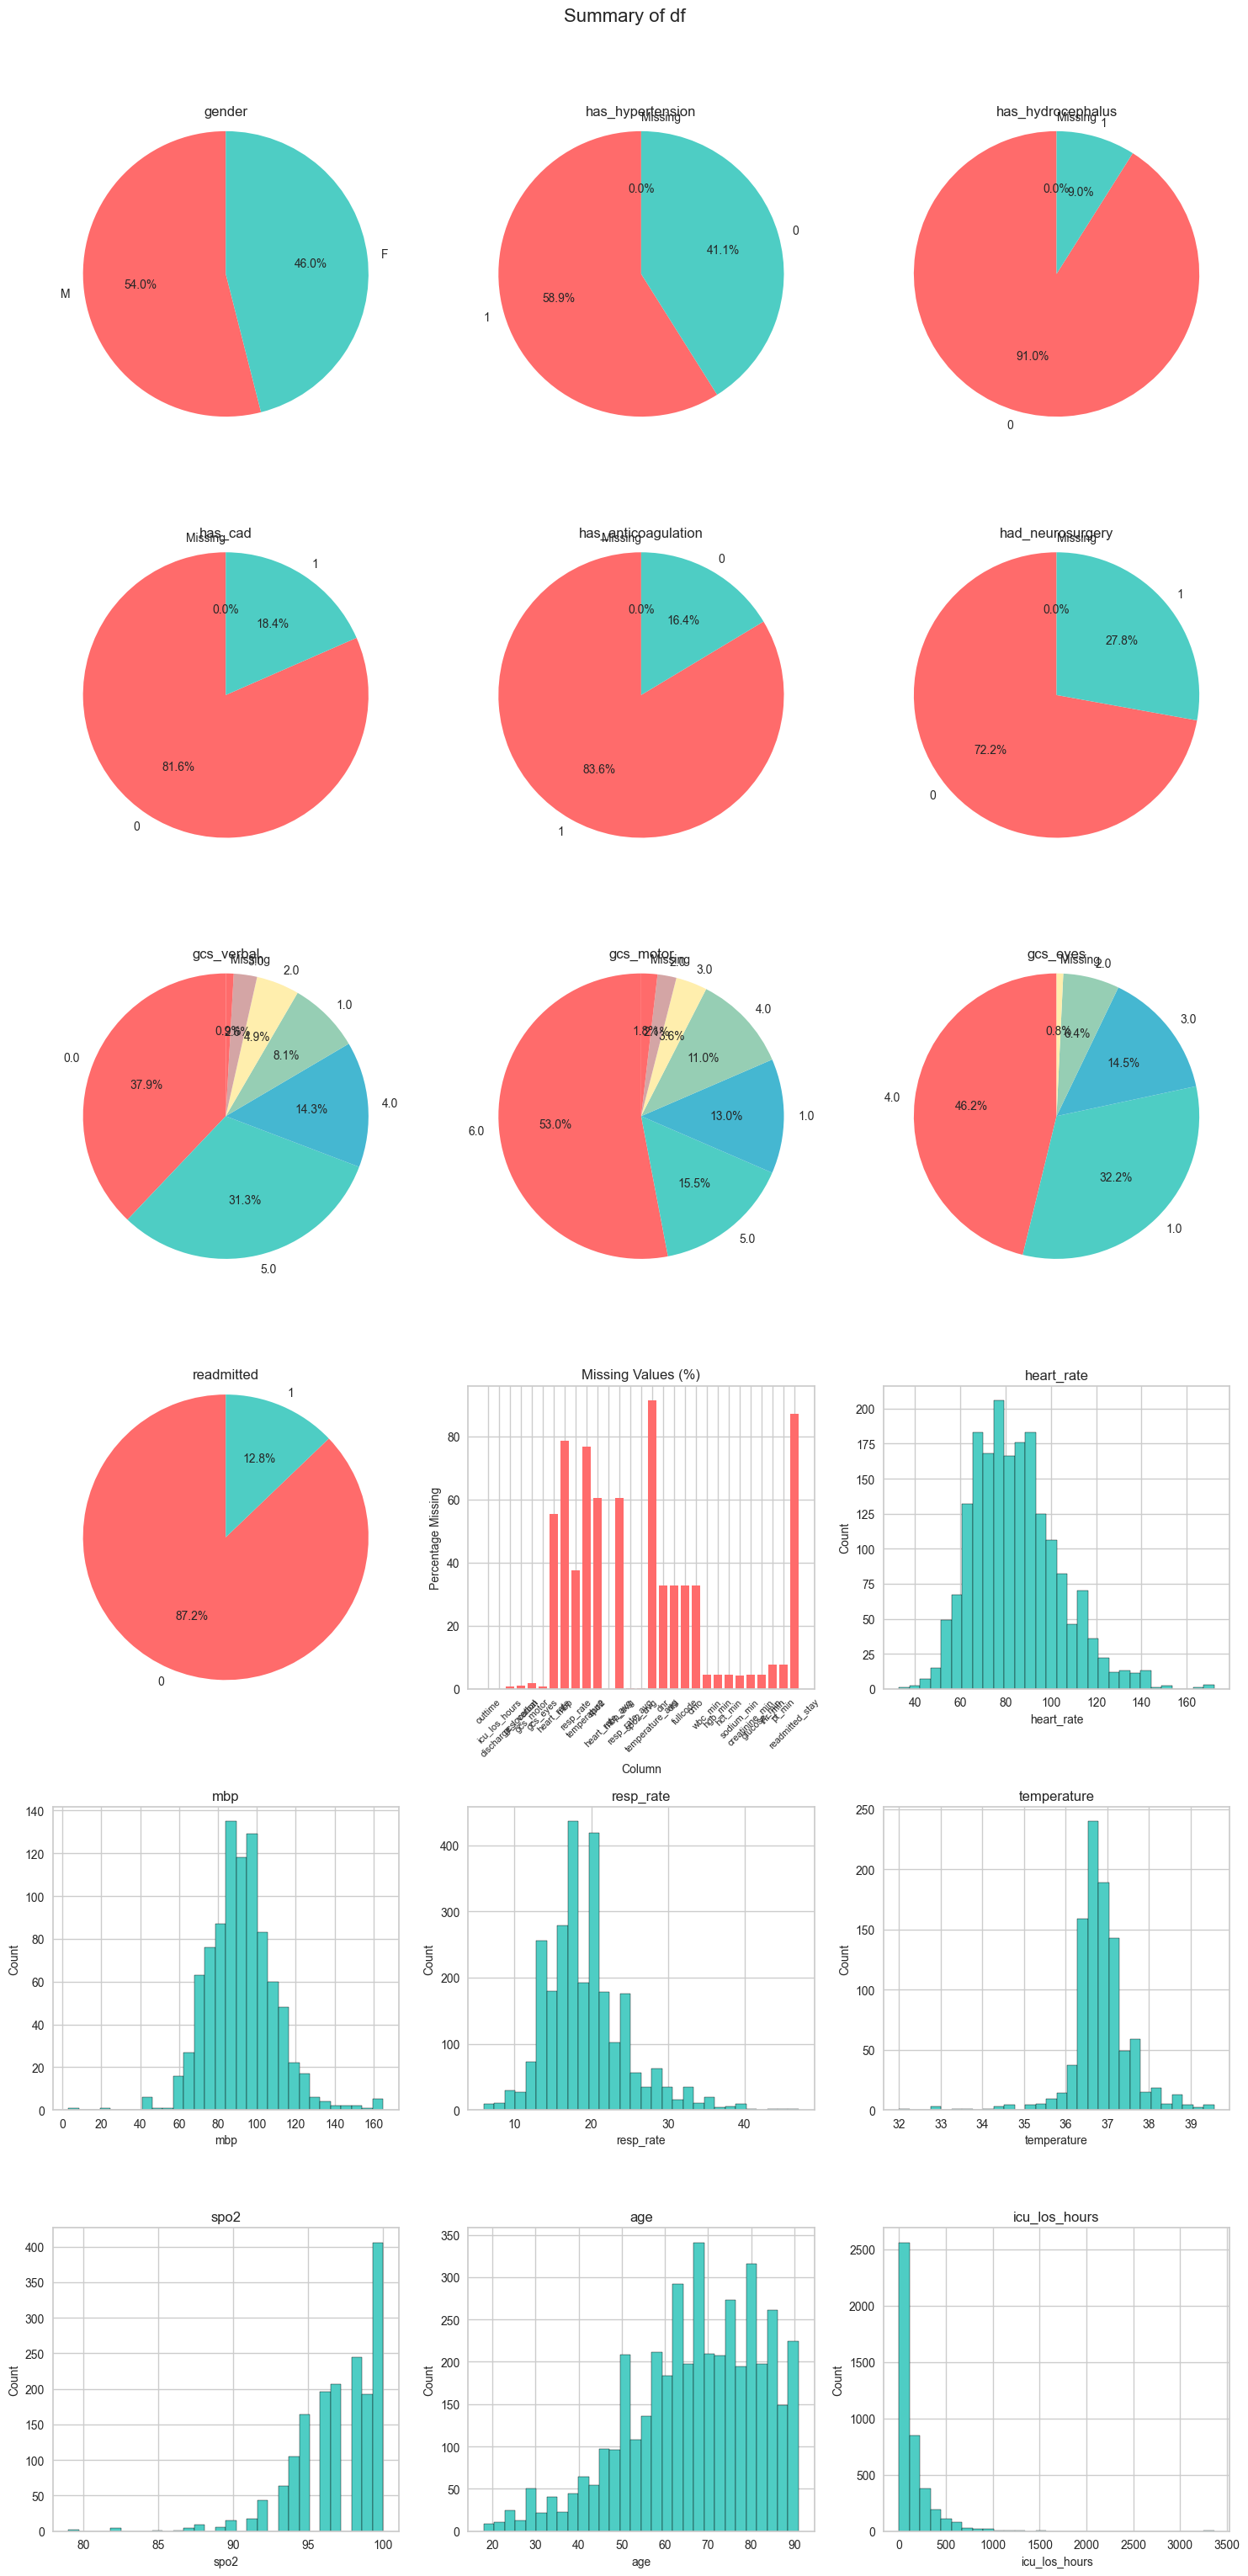

,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,non_ich_2724,non_ich_Z7901,non_ich_N179,ich_431,ich_I615,ich_I618,ich_I611,ich_I619,ich_I610,ich_I614
0,15206760,22941019,34608437,F,65,2133-09-06 02:49:00,2133-09-09 19:17:58,Neuro Surgical Intensive Care Unit (Neuro SICU),89,87,...,0,0,0,0,1,1,0,0,0,0
1,18217587,27289484,32792832,M,79,2125-04-30 03:39:00,2125-05-01 22:14:57,Neuro Intermediate,43,207,...,0,0,0,0,0,0,0,1,0,0
2,17689755,21438160,38033217,M,71,2182-05-18 12:52:31,2182-06-12 18:24:26,Neuro Intermediate,606,747,...,0,0,0,0,0,0,0,1,0,0
3,12026790,23977148,31641088,M,81,2154-12-14 05:58:00,2154-12-15 14:05:39,Neuro Intermediate,33,157,...,0,0,0,0,0,0,0,0,1,0
4,14415980,20050520,34506093,F,78,2122-06-14 21:56:00,2122-06-17 14:15:40,Neuro Surgical Intensive Care Unit (Neuro SICU),65,169,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,13671002,24843042,38940361,M,42,2122-03-21 18:50:00,2122-03-24 14:24:22,Trauma SICU (TSICU),68,66,...,1,0,0,1,0,0,0,0,0,0
4248,18225366,23045632,38301754,M,59,2156-12-16 21:35:00,2156-12-26 15:28:20,Neuro Surgical Intensive Care Unit (Neuro SICU),234,233,...,0,0,0,0,1,0,1,0,1,0
4249,16248948,25054367,37646192,M,54,2184-09-02 04:40:00,2184-09-03 10:39:46,Surgical Intensive Care Unit (SICU),30,18,...,0,0,0,1,0,0,0,0,0,0
4250,19332334,21729847,37357335,F,81,2139-04-15 15:17:00,2139-04-16 17:01:26,Surgical Intensive Care Unit (SICU),26,407,...,1,0,0,1,0,0,0,0,0,0


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal


# Define colors globally for use across all plots
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD', '#D4A5A5']

def plot_summary_charts(df, df_name):
    # Convert any Decimal values to float for all numerical columns
    numerical_cols = ['heart_rate', 'mbp', 'resp_rate', 'temperature', 'spo2', 'age', 'icu_los_hours']
    for col in numerical_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Define columns
    categorical_cols = ['gender', 'has_hypertension', 'has_hydrocephalus', 'has_cad', 
                       'has_anticoagulation', 'had_neurosurgery', 'gcs_verbal', 'gcs_motor', 'gcs_eyes', 'readmitted']
    numerical_cols = ['heart_rate', 'mbp', 'resp_rate', 'temperature', 'spo2', 'age', 'icu_los_hours']
    categorical_cols = [col for col in categorical_cols if col in df.columns]
    numerical_cols = [col for col in numerical_cols if col in df.columns]

    # Calculate number of subplots
    num_categorical = len(categorical_cols)
    num_numerical = len(numerical_cols)
    total_plots = num_categorical + num_numerical + 1  # +1 for missing values
    ncols = 3  # 3 columns for layout
    nrows = (total_plots + ncols - 1) // ncols  # Calculate rows needed

    # Create figure with subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Flatten for easier indexing
    plt.suptitle(f'Summary of {df_name}', fontsize=16, y=1.02)

    # Counter for subplot index
    plot_idx = 0

    # 1. Pie Charts for Categorical/Binary Columns
    for col in categorical_cols:
        if col in df.columns:
            value_counts = df[col].value_counts(dropna=False)
            labels = [str(x) if pd.notna(x) else 'Missing' for x in value_counts.index]
            sizes = value_counts.values

            axes[plot_idx].pie(sizes, labels=labels, colors=colors[:len(labels)], 
                              autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
            axes[plot_idx].set_title(f'{col}', fontsize=12)
            axes[plot_idx].axis('equal')
            
            plot_idx += 1

    # 2. Bar Chart for Missing Values
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
    missing_pct = missing_pct.astype(float)  # Ensure float type
    missing_data = pd.DataFrame({'Column': missing.index, 'Missing %': missing_pct})
    missing_data = missing_data[missing_data['Missing %'] > 0]

    if not missing_data.empty:
        axes[plot_idx].bar(missing_data['Column'], missing_data['Missing %'], color=colors[0])
        axes[plot_idx].set_title('Missing Values (%)', fontsize=12)
        axes[plot_idx].set_xlabel('Column', fontsize=10)
        axes[plot_idx].set_ylabel('Percentage Missing', fontsize=10)
        axes[plot_idx].tick_params(axis='x', rotation=45, labelsize=8)
    
        
        plot_idx += 1

    # 3. Histograms for Numerical Parameters
    for col in numerical_cols:
        if col in df.columns:
            data = df[col].dropna().astype(float)  # Convert to float
            if data.empty:
                axes[plot_idx].text(0.5, 0.5, f'No data for {col}', ha='center', va='center', fontsize=10)
                axes[plot_idx].set_title(f'{col}', fontsize=12)
            else:
                axes[plot_idx].hist(data, bins=30, color=colors[1], edgecolor='black')
                axes[plot_idx].set_title(f'{col}', fontsize=12)
                axes[plot_idx].set_xlabel(col, fontsize=10)
                axes[plot_idx].set_ylabel('Count', fontsize=10)
            
            
            plot_idx += 1

    # Remove empty subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_summary_charts(df, "df")

df


## 3. 🧽 Preprocesamiento



In [28]:
# Primer hauríem de mirar quins tipus de dades conté cada columna
print(df.dtypes)

subject_id       Int64
hadm_id          Int64
stay_id          Int64
gender        category
age              Int64
                ...   
ich_I618         int64
ich_I611         int64
ich_I619         int64
ich_I610         int64
ich_I614         int64
Length: 76, dtype: object


In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from decimal import Decimal

# Calculate missing percentages
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print("Missing percentages per column:")
print(missing_pct.sort_values(ascending=False))

# Set missing data threshold
missing_threshold = 60  # Exclude columns with >60% missing
columns_to_exclude = missing_pct[missing_pct > missing_threshold].index
print(f"\nColumns with >{missing_threshold}% missing: {list(columns_to_exclude)}")

# Exclude high-missingness columns, but keep readmitted_stay for target creation
features_to_keep = [col for col in df.columns if col not in columns_to_exclude or col == 'readmitted_stay']
df_clean = df.loc[:, features_to_keep]

# Handle Decimal values and fill NaNs
# Convert Decimal to float for numerical columns
numerical_cols = df_clean.select_dtypes(include=['number', 'Int64', 'float64', 'int64']).columns
for col in numerical_cols:
    df_clean.loc[:, col] = df_clean[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)

# Identify integer columns
int_columns = df_clean.select_dtypes(include=['Int64', 'int64']).columns
# Fill NaNs with rounded medians for integer columns
for col in int_columns:
    median_val = df_clean[col].median()
    if not pd.isna(median_val):
        df_clean.loc[:, col] = df_clean[col].fillna(int(median_val))

# Fill NaNs for other numeric columns, excluding readmitted_stay and readmitted
numeric_cols = df_clean.select_dtypes(include='number').columns.difference(['readmitted_stay', 'readmitted'])
df_clean.loc[:, numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

# Handle readmitted_stay separately
df_clean.loc[:, 'readmitted_stay'] = df_clean['readmitted_stay'].fillna(0)

# Scale features
scaler = StandardScaler()
feature_cols = df_clean.select_dtypes(include='number').columns[
    ~df_clean.select_dtypes(include='number').columns.str.startswith(('non_ich', 'ich'))
].difference(['readmitted_stay', 'readmitted', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'has_hypertension', 'has_hydrocephalus', 'has_cad', 'has_anticoagulation', 'had_neurosurgery'])
features_scaled = scaler.fit_transform(df_clean[feature_cols])
df_clean.loc[:, feature_cols] = features_scaled

# Remove columns that are not needed for the final dataset 
df_clean = df_clean.drop(columns=['intime', 'outtime', 'subject_id', 'hadm_id', 'stay_id', 'readmitted_stay', 'all_diagnoses','ich_icd_codes'], errors='ignore')

df_clean


Missing percentages per column:
temperature_avg                91.51
readmitted_stay                87.16
mbp                            78.53
temperature                    76.88
spo2                           60.49
                               ...  
had_neurosurgery                0.00
on_statins_or_antiplatelets     0.00
readmitted                      0.00
non_ich_I10                     0.00
ich_I614                        0.00
Length: 76, dtype: float64

Columns with >60% missing: ['mbp', 'temperature', 'spo2', 'mbp_avg', 'temperature_avg', 'readmitted_stay']


,gender,age,first_careunit,icu_los_hours,hosp_los_hours,discharge_location,hospital_expire_flag,gcs_verbal,gcs_motor,gcs_eyes,...,non_ich_2724,non_ich_Z7901,non_ich_N179,ich_431,ich_I615,ich_I618,ich_I611,ich_I619,ich_I610,ich_I614
0,F,-0.138986,Neuro Surgical Intensive Care Unit (Neuro SICU),-0.318743,-0.548464,DIED,1.590167,0.0,4.0,1.0,...,0,0,0,0,1,1,0,0,0,0
1,M,0.774211,Neuro Intermediate,-0.574457,-0.289993,REHAB,-0.628865,5.0,6.0,4.0,...,0,0,0,0,0,0,0,1,0,0
2,M,0.252384,Neuro Intermediate,2.555258,0.873129,REHAB,-0.628865,0.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,M,0.904667,Neuro Intermediate,-0.630047,-0.397689,SKILLED NURSING FACILITY,-0.628865,4.0,6.0,4.0,...,0,0,0,0,0,0,0,0,1,0
4,F,0.708982,Neuro Surgical Intensive Care Unit (Neuro SICU),-0.452159,-0.371842,REHAB,-0.628865,1.0,5.0,1.0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,M,-1.639238,Trauma SICU (TSICU),-0.435482,-0.593697,DIED,1.590167,0.0,5.0,1.0,...,1,0,0,1,0,0,0,0,0,0
4248,M,-0.530356,Neuro Surgical Intensive Care Unit (Neuro SICU),0.487312,-0.233991,DIED,1.590167,0.0,4.0,1.0,...,0,0,0,0,1,0,1,0,1,0
4249,M,-0.856498,Surgical Intensive Care Unit (SICU),-0.646724,-0.697085,DIED,1.590167,0.0,3.0,1.0,...,0,0,0,1,0,0,0,0,0,0
4250,F,0.904667,Surgical Intensive Care Unit (SICU),-0.668960,0.140793,SKILLED NURSING FACILITY,-0.628865,5.0,6.0,1.0,...,1,0,0,1,0,0,0,0,0,0


In [30]:
# Hauríem de mirar quins tipus de dades conté cada columna
print(df_clean.dtypes)

gender            category
age                float64
first_careunit      object
icu_los_hours      float64
hosp_los_hours     float64
                    ...   
ich_I618             int64
ich_I611             int64
ich_I619             int64
ich_I610             int64
ich_I614             int64
Length: 63, dtype: object


## 4. 📊 Modelado Predictivo

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from pycaret.classification import *

# Prepare data for PyCaret
ordinal_features = {
    'gcs_verbal': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    'gcs_motor':  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
    'gcs_eyes':   [0.0, 1.0, 2.0, 3.0, 4.0]
}
feature_cols = df_clean.columns.difference(['readmitted'])
X = df_clean[feature_cols]
y = df_clean['readmitted']
print("y value counts:", y.value_counts())
print("y unique values:", y.unique())

clf_setup = setup(
    data=df_clean,
    target='readmitted',
    ordinal_features=ordinal_features,
    normalize=False,
    session_id=42,
)

y value counts: readmitted
0    3706
1     546
Name: count, dtype: int64
y unique values: [0 1]


,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(4252, 63)"
4,Transformed data shape,"(4252, 97)"
5,Transformed train set shape,"(2976, 97)"
6,Transformed test set shape,"(1276, 97)"
7,Ordinal features,3
8,Numeric features,56
9,Categorical features,6


In [32]:
# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()


Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8733,0.7673,0.1150,0.5482,0.1865,0.1489,0.2043,0.0700
ridge,Ridge Classifier,0.8720,0.7524,0.0706,0.5507,0.1236,0.0956,0.1588,0.0290
dummy,Dummy Classifier,0.8716,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0300
lda,Linear Discriminant Analysis,0.8713,0.7519,0.2066,0.5008,0.2913,0.2338,0.2623,0.0310
lightgbm,Light Gradient Boosting Machine,0.8710,0.7748,0.1963,0.4973,0.2798,0.2236,0.2536,0.4740
lr,Logistic Regression,0.8706,0.7484,0.1283,0.4894,0.2022,0.1573,0.2003,0.0320
et,Extra Trees Classifier,0.8686,0.7360,0.1333,0.4613,0.2041,0.1563,0.1931,0.0620
gbc,Gradient Boosting Classifier,0.8676,0.7803,0.1438,0.4830,0.2185,0.1673,0.2068,0.1490
knn,K Neighbors Classifier,0.8612,0.6747,0.1253,0.3976,0.1884,0.1334,0.1620,0.0300
ada,Ada Boost Classifier,0.8609,0.7341,0.1439,0.4011,0.2103,0.1515,0.1769,0.0520


In the initial round of model evaluation, most classifiers achieved high accuracy (around 77%) but extremely low recall and F1 scores. This indicated that the models were predominantly predicting the majority class (i.e., not readmitted), failing to identify actual readmission cases. For example, Ridge Classifier and Logistic Regression had recall values below 2%, and the Dummy Classifier set a high baseline accuracy simply by predicting all negatives. These results highlighted the impact of class imbalance and the need for better strategies to detect minority class cases.

In [17]:
clf_setup = setup(
    data=df_clean,
    target='readmitted',
    ordinal_features=ordinal_features,
    normalize=False,
    session_id=42,
    fix_imbalance=True,
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()

,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(3718, 45)"
4,Transformed data shape,"(5134, 58)"
5,Transformed train set shape,"(4018, 58)"
6,Transformed test set shape,"(1116, 58)"
7,Ordinal features,3
8,Numeric features,40
9,Categorical features,4



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.7721,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0250
rf,Random Forest Classifier,0.7448,0.6721,0.1382,0.3425,0.1948,0.0775,0.0883,0.0780
et,Extra Trees Classifier,0.7410,0.6535,0.1450,0.3503,0.2030,0.0783,0.0908,0.0710
lightgbm,Light Gradient Boosting Machine,0.7367,0.6732,0.1887,0.3557,0.2456,0.1043,0.1123,0.5150
gbc,Gradient Boosting Classifier,0.7364,0.6868,0.2411,0.3775,0.2908,0.1404,0.1466,0.1300
ada,Ada Boost Classifier,0.6672,0.6562,0.3879,0.3165,0.3475,0.1282,0.1294,0.0480
dt,Decision Tree Classifier,0.6614,0.5400,0.3170,0.2834,0.2987,0.0769,0.0772,0.0310
lr,Logistic Regression,0.6057,0.6779,0.6761,0.3253,0.4388,0.1894,0.2198,0.0260
qda,Quadratic Discriminant Analysis,0.5996,0.5985,0.5087,0.2930,0.3674,0.1102,0.1184,0.0220
lda,Linear Discriminant Analysis,0.5968,0.6733,0.6930,0.3218,0.4390,0.1858,0.2199,0.0250


After addressing class imbalance (e.g., via PyCaret's fix_imbalance=True), model performance improved substantially. Recall scores increased significantly across models, with Naive Bayes achieving a recall of 83% and Logistic Regression and Ridge Classifier reaching around 66–68%. F1 scores also improved (up to 0.40), indicating a better balance between precision and recall. Although overall accuracy decreased slightly (to ~55% for the best-performing balanced models), the models were now much more capable of detecting actual readmissions, which was the primary goal.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7395,0.6454,0.1000,0.3000,0.1500,0.0396,0.0480
1,0.7625,0.6727,0.1500,0.4500,0.2250,0.1244,0.1507
2,0.7423,0.7357,0.1186,0.3182,0.1728,0.0565,0.0662
3,0.7462,0.6489,0.1356,0.3478,0.1951,0.0777,0.0899
4,0.7462,0.6723,0.1864,0.3793,0.2500,0.1181,0.1289
5,0.7500,0.6587,0.1864,0.3929,0.2529,0.1251,0.1376
6,0.7500,0.7035,0.0508,0.2500,0.0845,0.0084,0.0121
7,0.7577,0.7233,0.1525,0.4091,0.2222,0.1129,0.1322
8,0.7038,0.6151,0.0678,0.1538,0.0941,-0.0519,-0.0582


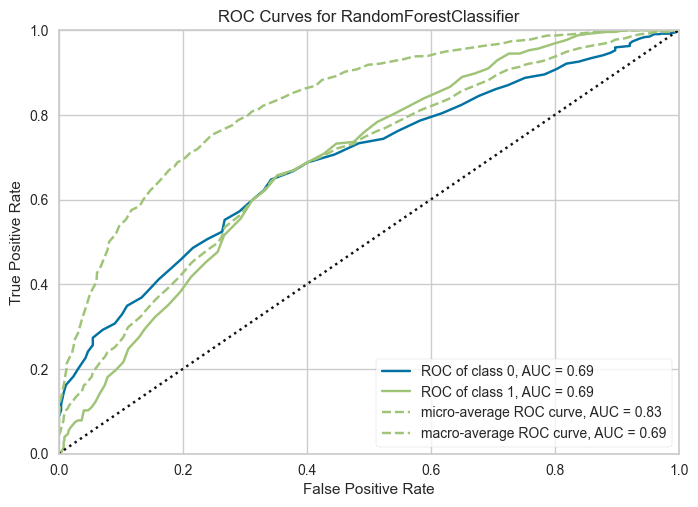

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [18]:
from pycaret.classification import plot_model, create_model
rf_model = create_model('rf')
plot_model(rf_model, plot='auc')
# Evaluate the model
evaluate_model(rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5977,0.6496,0.7000,0.3256,0.4444,0.1904,0.2248
1,0.6513,0.7182,0.6833,0.3628,0.4740,0.2482,0.2761
2,0.6077,0.7044,0.7288,0.3333,0.4574,0.2121,0.2521
3,0.5769,0.6377,0.5932,0.2893,0.3889,0.1206,0.1389
4,0.6269,0.6875,0.7119,0.3443,0.4641,0.2279,0.2634
5,0.6038,0.6620,0.6610,0.3197,0.4309,0.1801,0.2082
6,0.6192,0.6922,0.6271,0.3246,0.4277,0.1836,0.2060
7,0.6231,0.6988,0.6271,0.3274,0.4302,0.1882,0.2104
8,0.5538,0.6656,0.7288,0.3007,0.4257,0.1539,0.1947


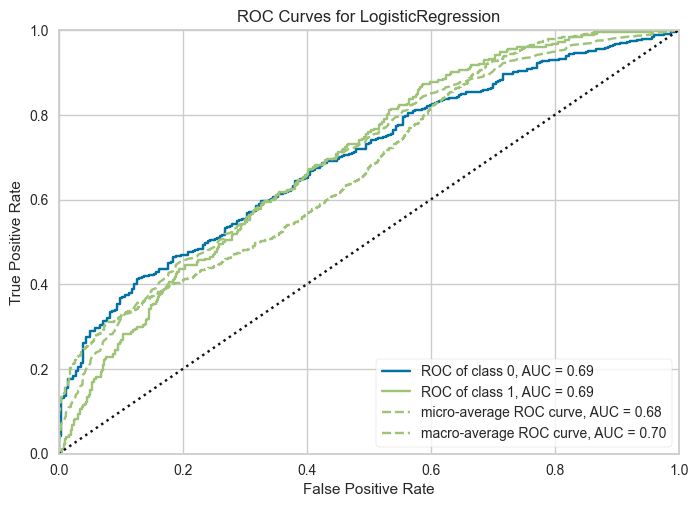

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [19]:
from pycaret.classification import plot_model, create_model
lr_model = create_model('lr')
plot_model(lr_model, plot='auc')
# Evaluate the model
evaluate_model(lr_model)

In [20]:
from pycaret.classification import create_model, get_config
# Get the underlying scikit-learn model
lr_estimator = lr_model.named_steps['actual_estimator'] if 'actual_estimator' in dir(lr_model) else lr_model
# Get coefficients and feature names
coefficients = lr_estimator.coef_[0]
feature_names = get_config('X').columns
# Calculate odds ratios
odds_ratios = np.exp(coefficients)
# Display odds ratios
for feature, odds in zip(feature_names, odds_ratios):
    print(f"Feature: {feature}, Odds Ratio: {odds:.3f}")


Feature: gender, Odds Ratio: 0.979
Feature: age, Odds Ratio: 0.775
Feature: icu_los_hours, Odds Ratio: 0.974
Feature: gcs_verbal, Odds Ratio: 0.695
Feature: gcs_motor, Odds Ratio: 1.164
Feature: gcs_eyes, Odds Ratio: 1.239
Feature: heart_rate, Odds Ratio: 0.967
Feature: resp_rate, Odds Ratio: 0.902
Feature: spo2, Odds Ratio: 0.874
Feature: heart_rate_avg, Odds Ratio: 1.224
Feature: resp_rate_avg, Odds Ratio: 0.707
Feature: spo2_avg, Odds Ratio: 1.232
Feature: has_hypertension, Odds Ratio: 0.922
Feature: has_hydrocephalus, Odds Ratio: 1.490
Feature: has_cad, Odds Ratio: 0.522
Feature: has_anticoagulation, Odds Ratio: 0.697
Feature: had_neurosurgery, Odds Ratio: 0.952
Feature: non_ich_I10, Odds Ratio: 1.172
Feature: non_ich_E785, Odds Ratio: 0.982
Feature: non_ich_G936, Odds Ratio: 0.931
Feature: non_ich_4019, Odds Ratio: 1.000
Feature: non_ich_Z66, Odds Ratio: 0.970
Feature: non_ich_R29810, Odds Ratio: 1.092
Feature: non_ich_3485, Odds Ratio: 1.089
Feature: non_ich_Z515, Odds Ratio: 1.1

In [21]:
# Paso 6: Afinar el Modelo
print("\nAfinando el modelo...")
ridge_tunned = tune_model(ridge_model)



Afinando el modelo...


NameError: name 'ridge_model' is not defined

In [22]:
# Paso 8: Guardar y Cargar el Modelo
print("\nGuardando el modelo...")
save_model(ridge_tunned, 'modelo_ridge_afinado')

# Cargar el modelo guardado
print("\nCargando el modelo guardado...")
loaded_model = load_model('modelo_ridge_afinado')


Guardando el modelo...


NameError: name 'ridge_tunned' is not defined

## 5. 📈 Visualización de Resultados

In [23]:
from pycaret.classification import plot_model

# Plot the ROC-AUC curve for the ridge model
plot_model(ridge_model, plot='auc')

NameError: name 'ridge_model' is not defined

## 6. 🚀 Despliegue (Futuro)
Se puede utilizar Hugging Face Spaces o Streamlit Cloud para desplegar un frontend que permita:
- Cargar variables clínicas
- Obtener un score de riesgo
- Visualizar el gráfico ROC o una matriz de confusión